<b>DOMAIN:</b> Semiconductor manufacturing process

<b>CONTEXT: </b> A complex modern semiconductor manufacturing process is normally under constant surveillance via the monitoring of signals/
variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific
monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. Engineers
typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature
selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors
contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning
and reduce the per unit production costs. These signals can be used as features to predict the yield type. And by analysing and trying out
different combinations of features, essential signals that are impacting the yield type can be identified.

<b>DATA DESCRIPTION:</b> sensor-data.csv : (1567, 592)
The data consists of 1567 examples each with 591 features.
The dataset presented in this case represents a selection of such features where each example represents a single production entity with
associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column “ –1” corresponds to
a pass and “1” corresponds to a fail and the data time stamp is for that specific test point.

<b>PROJECT OBJECTIVE:</b> We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the
features are required to build the model or not.

<b>Steps and tasks: </b>

1. Import and explore the data.

In [2]:
# all imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd


from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from collections import Counter
from statistics import mean
from scipy.stats import ttest_ind
import time

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

# crossvalidation techniques
from sklearn.model_selection import LeaveOneOut,GridSearchCV
from sklearn.utils import resample

#classifiers and metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression

# feature reduction/elimination
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

#pipeline
from sklearn.pipeline import Pipeline 

#cross validation
from sklearn.model_selection import RandomizedSearchCV

#import pickle
import pickle

#graphs
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
data_signal = pd.read_csv("Signal-data.csv",header=0) # read input file
data_signal.shape,data_signal.info() # explore shape and info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(591), object(1)
memory usage: 7.1+ MB


((1567, 592), None)

In [5]:
data_signal.isnull().sum(axis=0).sort_values(ascending=False) # check for null values

293     1429
292     1429
157     1429
158     1429
85      1341
358     1341
220     1341
492     1341
382     1018
383     1018
111     1018
110     1018
109     1018
384     1018
245     1018
246     1018
244     1018
516     1018
517     1018
518     1018
580      962
581      962
579      962
578      962
346      802
73       802
345      802
72       802
519      726
385      726
        ... 
588       18
389       18
388       18
387       18
223       18
88        18
113       18
114       18
115       18
116       18
117       18
119       18
120       18
156       18
221       18
222       18
248       18
386       18
249       18
250       18
251       18
252       18
254       18
255       18
291       18
589       18
359       18
360       18
361       18
Time      18
Length: 592, dtype: int64

In [6]:
data_signal.head(25), data_signal.tail(25)

(                Time        0        1          2          3       4      5  \
 0   22-07-2008 11:47  3040.34  2501.16  2207.3889   962.5317  1.2043  100.0   
 1   22-07-2008 14:00  2988.30  2519.05  2208.8556  1157.7224  1.5509  100.0   
 2   22-07-2008 15:30  2987.32  2528.81        NaN        NaN     NaN    NaN   
 3   23-07-2008 05:15      NaN  2481.85  2207.3889   962.5317  1.2043  100.0   
 4   23-07-2008 19:22  3002.27  2497.45  2207.3889   962.5317  1.2043  100.0   
 5   25-07-2008 15:23  2884.74  2514.54  2160.3667   899.9488  1.4022  100.0   
 6   27-07-2008 04:18  3010.41  2632.80  2203.9000  1116.4129  1.2639  100.0   
 7   27-07-2008 09:37  2979.74  2446.56  2257.1667  1437.9565  1.4918  100.0   
 8   27-07-2008 11:10  3067.35  2456.33  2257.1667  1437.9565  1.4918  100.0   
 9   27-07-2008 15:46  2988.99  2607.63  2223.0333  1533.9934  1.3548  100.0   
 10  27-07-2008 16:06  2972.78  2431.57  2190.4889  1059.4390  0.8614  100.0   
 11  27-07-2008 16:49  2981.85  2529.11 

In [7]:
# In this dataset, last column looks like is shifted by 18 rows. 
# Assuming, its shifted, shift it back 
data_signal['Pass/Fail'] = data_signal['Pass/Fail'].shift(periods=-18,axis=0) # shift the 18 rows up for last column

In [8]:
# Drop the last 18 rows that has only null values.
data_signal.drop(data_signal.tail(18).index,inplace=True) # drop last 18 rows

In [9]:
data_signal.tail(25)

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
1524,15-10-2008 22:54,2965.57,2487.91,2210.3556,910.7177,1.6941,100.0,119.8822,0.1268,1.3109,...,121.9426,0.4992,0.0136,0.0037,2.7204,0.0216,0.0263,0.0087,121.9426,-1.0
1525,15-10-2008 23:00,3109.18,2447.97,2210.3556,910.7177,1.6941,100.0,119.8822,0.1268,1.3502,...,50.8827,0.4975,0.0109,0.0038,2.1905,0.0273,0.0139,0.0055,50.8827,-1.0
1526,15-10-2008 23:45,3108.98,2537.73,2210.3556,910.7177,1.6941,100.0,119.8822,0.1268,1.2901,...,72.9676,0.4986,0.0192,0.0046,3.8442,0.0172,0.0126,0.0039,72.9676,-1.0
1527,16-10-2008 02:16,3100.19,2490.60,2212.8445,1068.5644,1.7835,100.0,113.8833,0.1249,1.4294,...,402.6874,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874,-1.0
1528,16-10-2008 02:16,3093.24,2488.18,2212.8445,1068.5644,1.7835,100.0,113.8833,0.1249,1.3482,...,105.7142,0.5022,0.0249,0.0049,4.9623,0.0134,0.0142,0.0047,105.7142,-1.0
1529,16-10-2008 02:17,3008.77,2542.36,2167.4222,2837.8788,1.4892,100.0,83.8222,0.1255,1.2895,...,36.2975,0.5012,0.0160,0.0044,3.2008,0.0222,0.0080,0.0022,36.2975,-1.0
1530,16-10-2008 02:22,3027.01,2464.98,2212.6334,1081.5662,1.0096,100.0,113.4278,0.1253,1.4410,...,88.5812,0.4944,0.0171,0.0040,3.4656,0.0253,0.0224,0.0071,88.5812,-1.0
1531,16-10-2008 02:55,3183.63,2498.00,2195.4444,2914.1792,1.5978,100.0,85.1011,0.1235,1.4129,...,NaN,0.5037,0.0117,0.0030,2.3203,0.0253,0.0224,0.0071,88.5812,-1.0
1532,16-10-2008 03:56,3072.20,2406.47,2195.4444,2914.1792,1.5978,100.0,85.1011,0.1235,1.3148,...,27.5514,0.5034,0.0178,0.0043,3.5459,0.0236,0.0065,0.0022,27.5514,-1.0
1533,16-10-2008 04:02,2958.43,2489.06,2192.7556,867.3027,1.7393,100.0,123.4244,0.1251,1.4386,...,30.7574,0.4972,0.0157,0.0040,3.1578,0.0400,0.0123,0.0044,30.7574,-1.0


In [10]:
data_signal.shape

(1549, 592)

2. <b> Data cleansing:</b>
• Missing value treatment.
• Drop attribute/s if required using relevant functional knowledge.
• Make all relevant modifications on the data using both functional/logical reasoning/assumptions

In [11]:
(data_signal.isnull().sum(axis=0)>150).sum() #columns for which 10% of rows or more are null

52

In [12]:
# drop these 52 ccolumns that have 10% or more rows as null
p_data=data_signal.copy() # take a copy of the dataset

p_data=p_data.loc[:,(data_signal.isnull().sum(axis=0)<=150)]
p_data.shape

(1549, 540)

In [13]:
p_data['Pass/Fail'].value_counts()  # checking to see number of nulls in label column

-1.0    1449
 1.0     100
Name: Pass/Fail, dtype: int64

In [14]:
# Lets replace null with median values.
p_data.fillna(p_data.median(),inplace=True) #replace null with median values
p_data.isnull().sum().sum() #  check for nulls after replacement

0

In [15]:
# check columns that doesnt have any variance and has only constant values throughout and remove them

columns=p_data.describe().T[(p_data.describe().T.sort_values(by='std')['std']!=0)].index # many columns without variance. These can be removed
p_data = p_data.loc[:,columns] # have only columns that have variance
p_data.describe().T.sort_values(by='std').head(10) # check top 10 rows of new dataset

,count,mean,std,min,25%,50%,75%,max
95,1549.0,0.000059,0.000104,-0.0009,0.0000,0.0000,0.0001,0.0009
94,1549.0,-0.000029,0.000174,-0.0020,-0.0001,0.0000,0.0001,0.0011
101,1549.0,-0.000007,0.000221,-0.0024,-0.0001,0.0000,0.0001,0.0017
544,1549.0,0.002508,0.000297,0.0016,0.0024,0.0026,0.0026,0.0047
278,1549.0,0.001119,0.000340,0.0000,0.0009,0.0011,0.0013,0.0034
100,1549.0,-0.000022,0.000355,-0.0030,-0.0002,0.0000,0.0002,0.0023
377,1549.0,0.001571,0.000467,0.0004,0.0013,0.0015,0.0018,0.0077
357,1549.0,0.000997,0.000496,0.0003,0.0007,0.0009,0.0011,0.0052
376,1549.0,0.001598,0.000533,0.0004,0.0013,0.0016,0.0019,0.0082
104,1549.0,-0.000014,0.000852,-0.0119,-0.0004,0.0000,0.0004,0.0071


In [16]:
p_data.drop_duplicates(inplace=True) # drop duplicates

In [17]:
p_data.shape # there are 423 columns that have variance and more than 90% of valid values

(1549, 423)

<b>3. Data analysis & visualisation: </b>
• Perform detailed relevant statistical analysis on the data.
• Perform a detailed univariate, bivariate and multivariate analysis with appropriate detailed comments after each analysis. 

In [16]:
# plt.subplots(1,1,figsize=(30,10))
corr = p_data.corr()
# sns.heatmap(corr,annot=True,cmap='coolwarm', vmin=-1, vmax=1, fmt='.1f',linewidths=.5,center=0,cbar=False)

In [18]:
# Perform train_test split
# dependent variable
y = p_data['Pass/Fail']

# independent variable
x= p_data.iloc[:,:-1]

##### Dataset has target imbalance

In [22]:
skb = SelectKBest(k=15)
x_new = skb.fit_transform(x,y) # select top 20 features
x_new.shape

(1549, 15)

In [23]:
columns=skb.get_support(indices=False).tolist() # get list of column index
col=x.columns[columns].tolist() # get column names
x_new_df=pd.DataFrame(x_new,columns=col) # create dataframe
x_new_df.shape

(1549, 15)

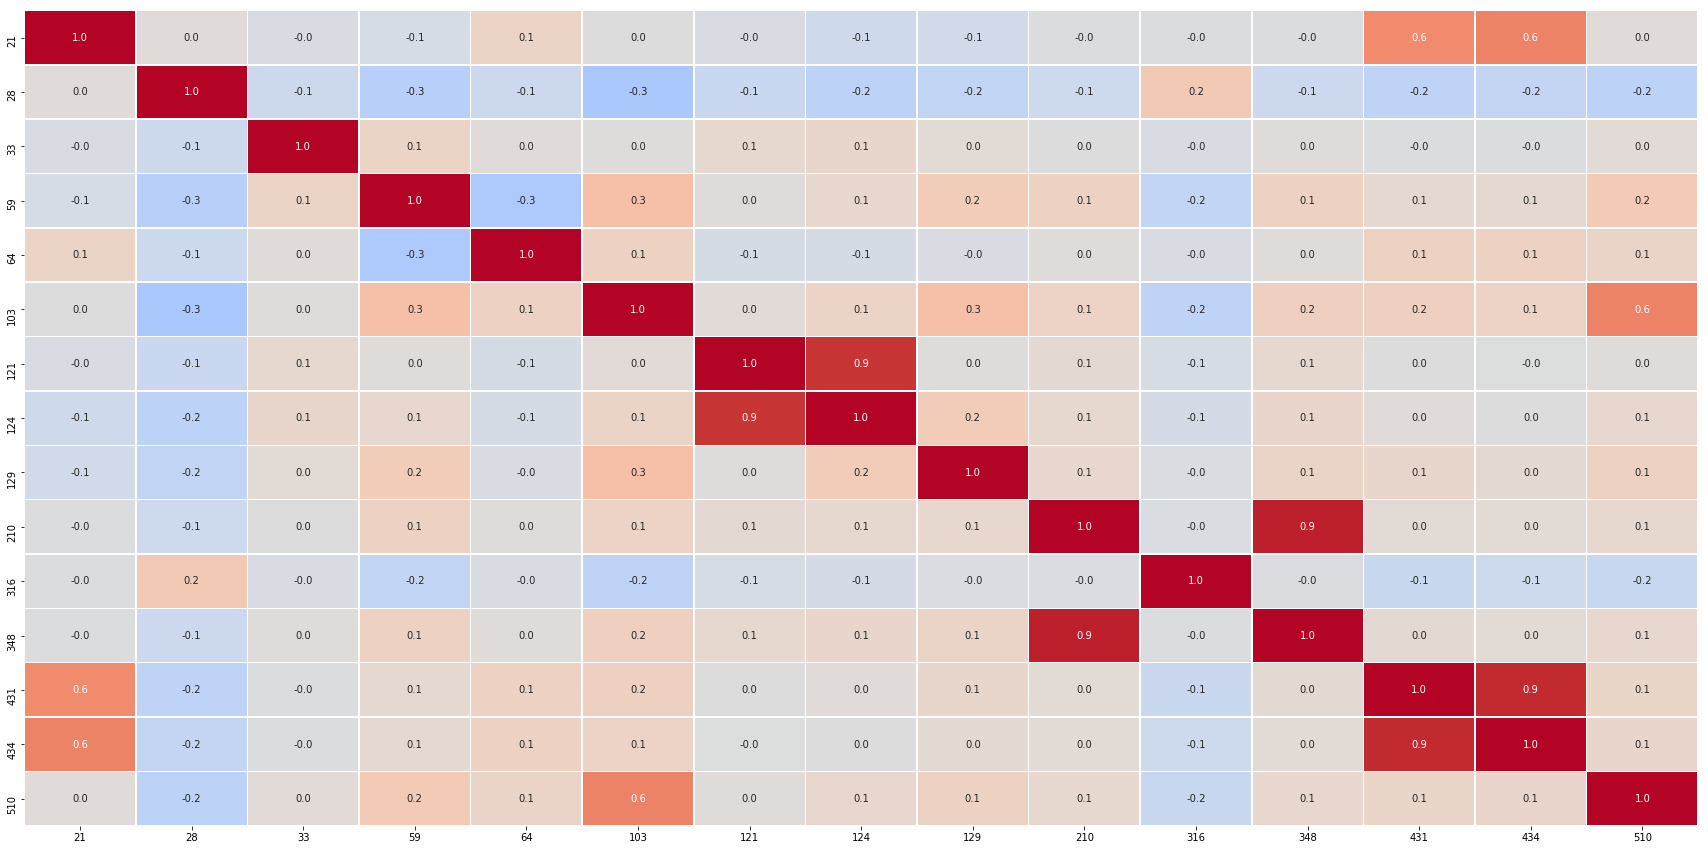

In [23]:
corr=x_new_df.corr() # analyse the top 15 attributes
plt.subplots(1,1,figsize=(30,15))
sns.heatmap(corr,annot=True,cmap='coolwarm', vmin=-1, vmax=1, fmt='.1f',linewidths=.5,center=0,cbar=False)

##### Even amongst top 20 attributes, perfect positive correlation exists between some of these attributes. Example: 152,287 and 425

In [24]:
col.append('Pass/Fail') # append y label to column names

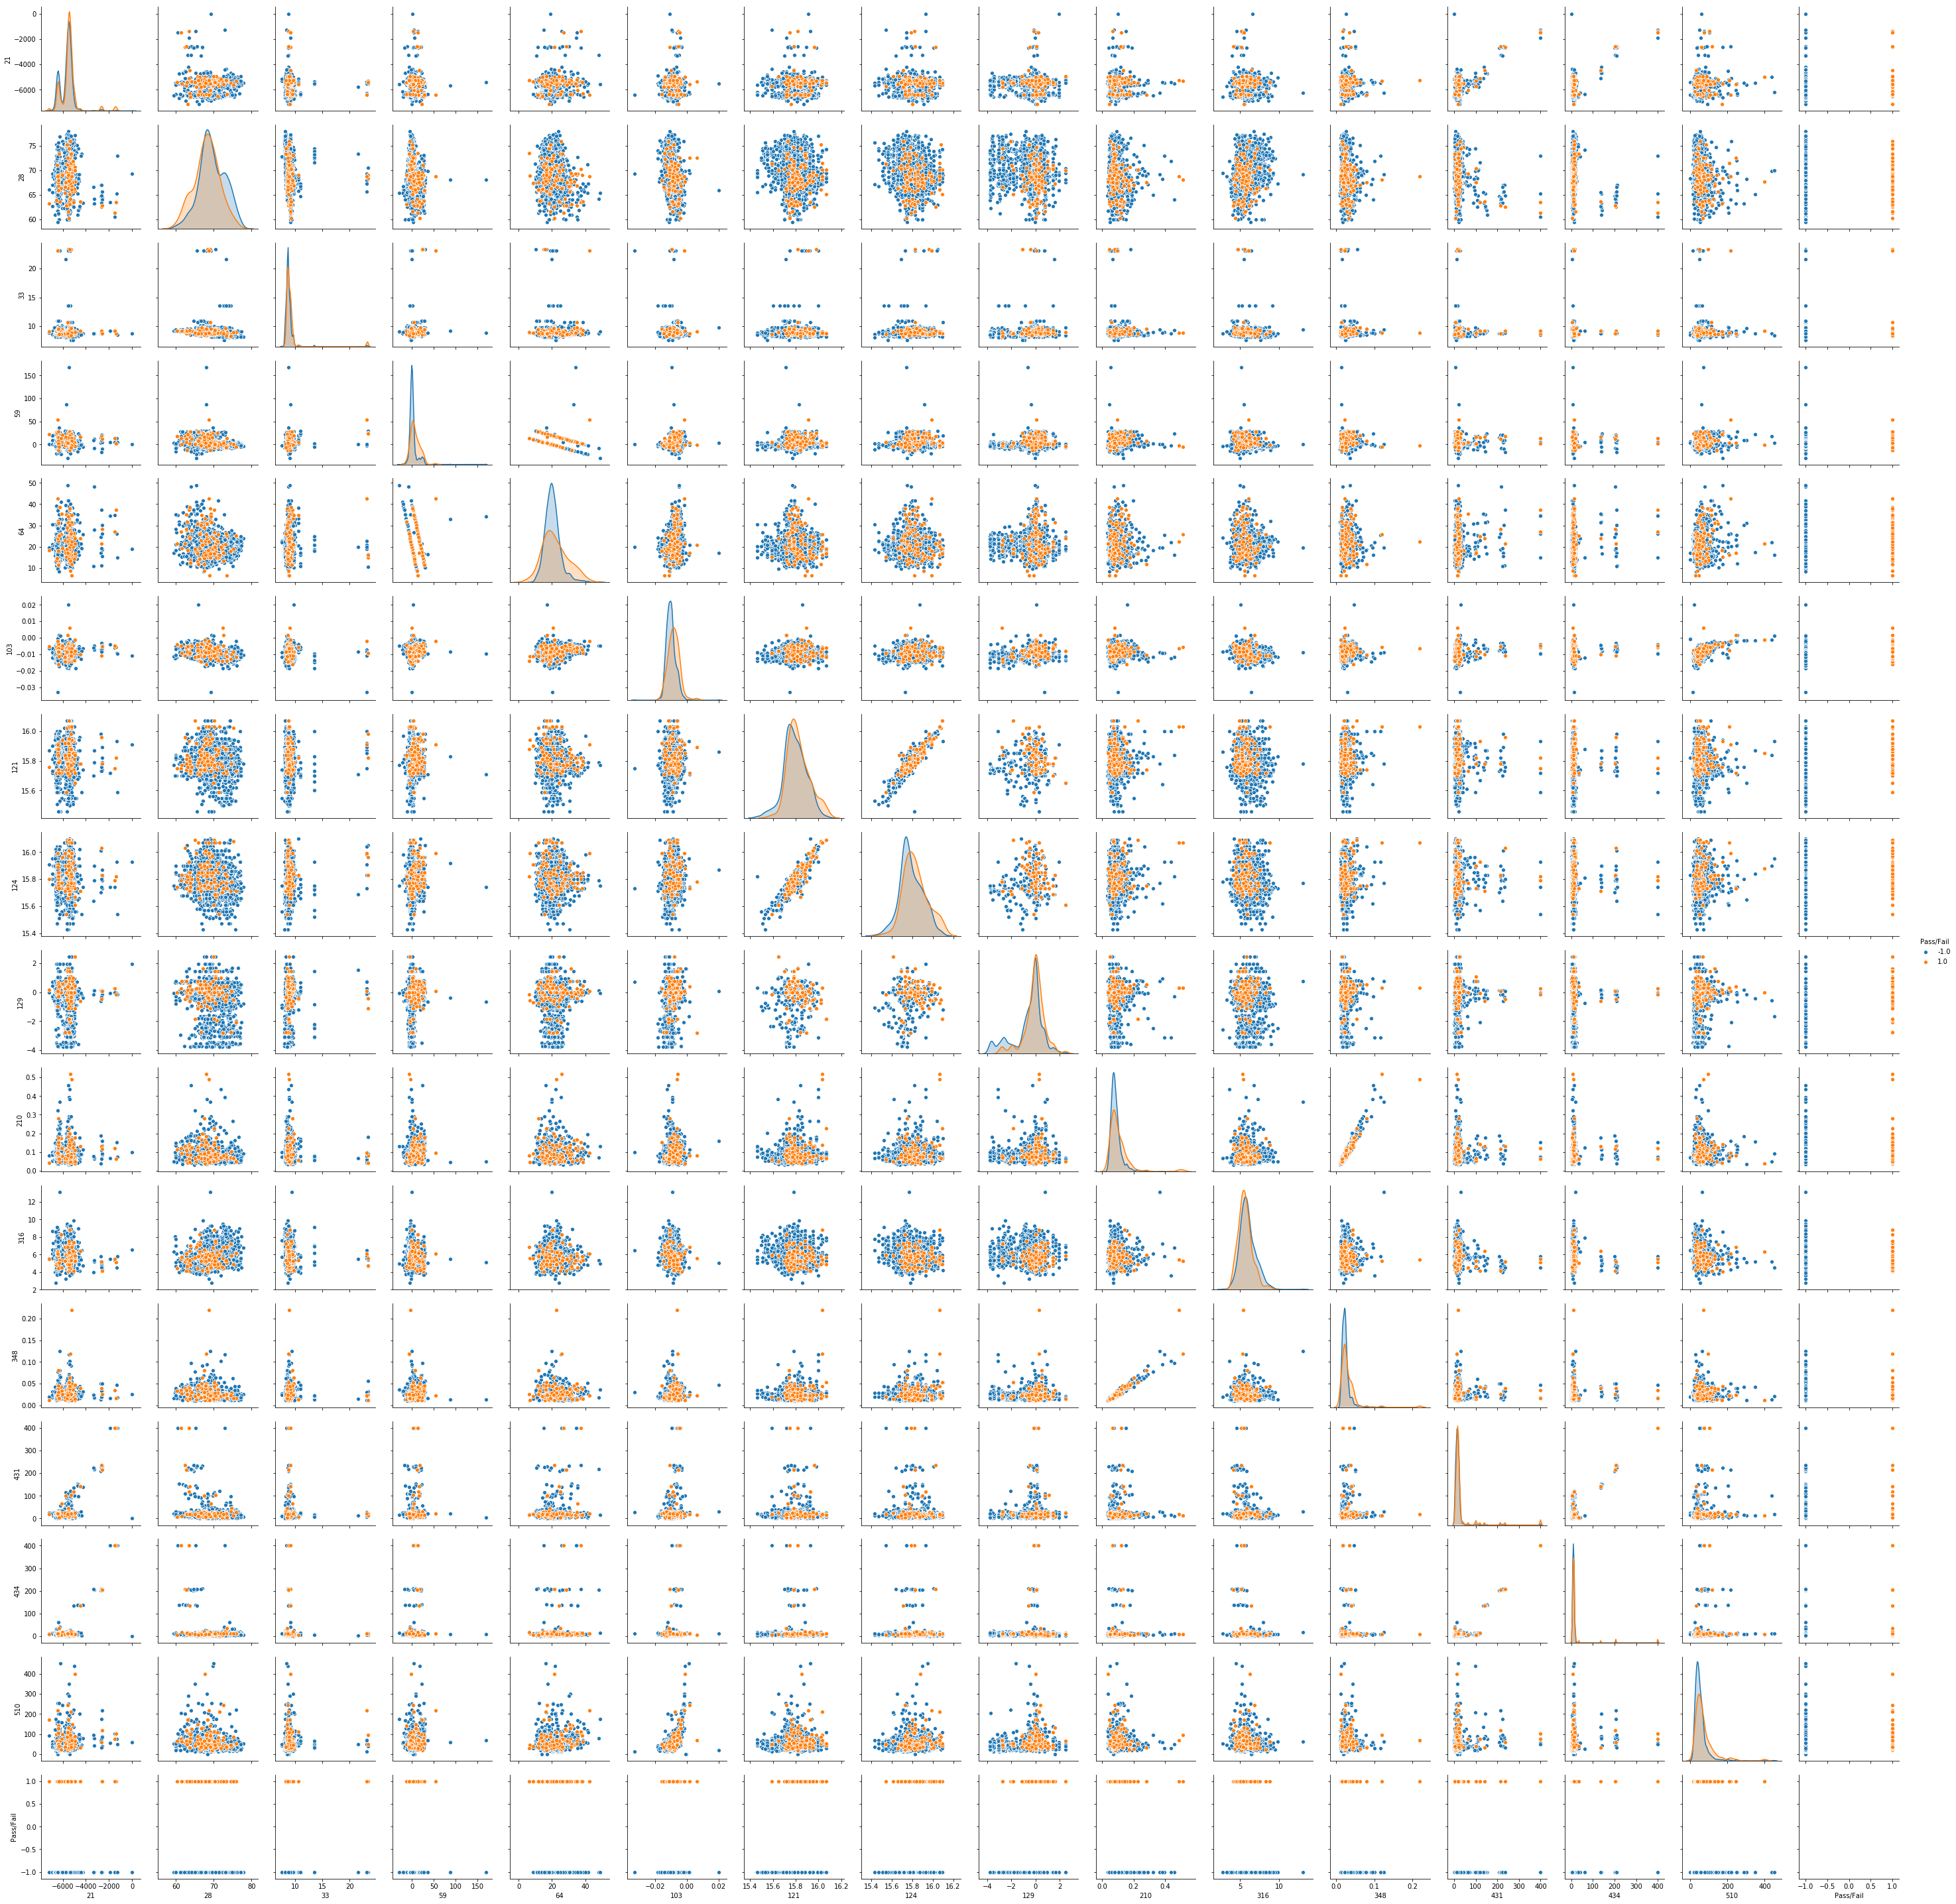

In [25]:
sns.pairplot(data=p_data[col], diag_kind= 'kde', hue='Pass/Fail') # create pairplot

In [26]:
p_data[col].describe()

,21,28,33,59,64,103,121,124,129,210,316,348,431,434,510,Pass/Fail
count,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000
mean,-5625.246611,69.559165,8.958943,2.824898,20.564586,-0.009843,15.796243,15.794367,-0.557754,0.088772,5.983959,0.024673,21.802757,14.210048,55.048771,-0.870884
std,610.412637,3.421627,1.351062,9.363771,4.949901,0.003036,0.099530,0.114135,1.222386,0.041781,1.019970,0.011769,34.391404,31.976871,36.801698,0.491647
min,-7150.250000,59.400000,7.603200,-28.988200,6.448200,-0.032900,15.460000,15.430000,-3.779000,0.031900,2.788200,0.010600,0.000000,0.000000,0.000000,-1.000000
25%,-5933.250000,67.422200,8.578800,-1.870900,17.403600,-0.011800,15.730000,15.730000,-0.898800,0.066000,5.313400,0.018200,11.059000,7.550700,35.272000,-1.000000
50%,-5523.750000,69.211100,8.769600,0.909550,20.039500,-0.010100,15.790000,15.775000,-0.141900,0.079800,5.837950,0.022700,16.314900,10.203300,46.647200,-1.000000
75%,-5356.250000,72.277800,9.044700,4.165500,22.810000,-0.008300,15.860000,15.870000,0.047300,0.099000,6.554000,0.027300,21.640700,12.751400,63.621000,-1.000000
max,0.000000,77.900000,23.345300,168.145500,48.988200,0.020300,16.070000,16.100000,2.458000,0.516400,13.095800,0.220000,400.000000,400.000000,451.485100,1.000000


##### Presence of big outliers in many of these key variables


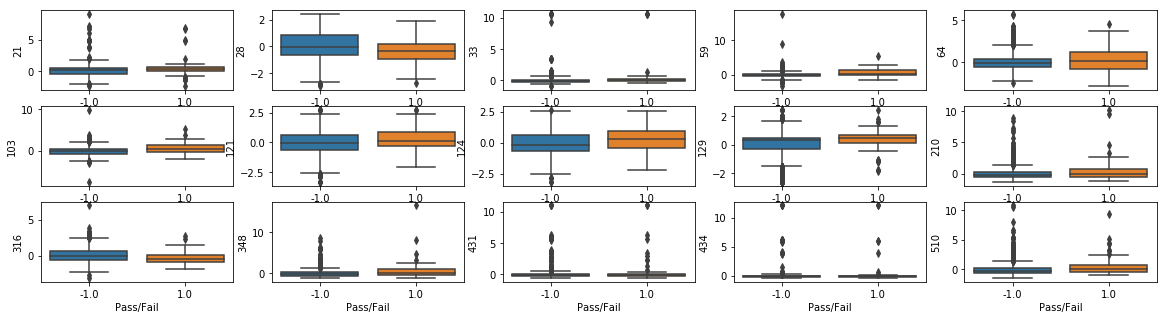

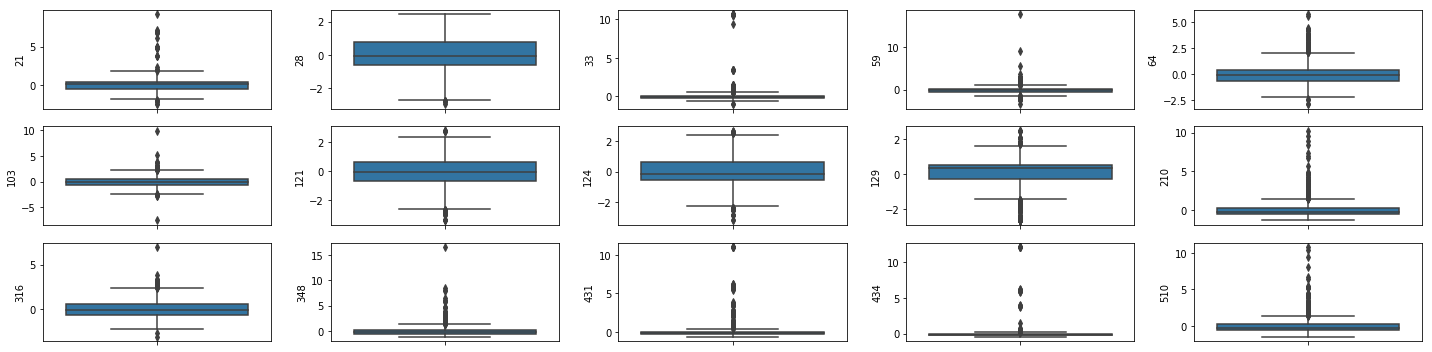

In [27]:
# Look at spread of continuous variables
fig, axs = plt.subplots(3,5,figsize=(20,5))
fig, axs1 = plt.subplots(3,5,figsize=(20,5))

continuous = col[:-1] # assign all but the label column

p_data_zscore = p_data.copy() #create a copy of the dataset before applying zscore
p_data_zscore[continuous]= p_data_zscore[continuous].apply(zscore) #apply zscore

plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10)     # fontsize of the x and y labels

row = 0
position = 0

for i in range(0,len(continuous)): # continuous is declared earlier
    
    y=continuous[i]
    
    # set position of subplot using mod operator
    position = (i+1) % 5
    if  position == 0:
        position = 5 # if 4th position, mod will be 0. Set it to 5.

    # set row of subplot using i
    if ((i+1)%5==1) and i!=0 :
        row = row+1
    
    # boxplot by origin
    sns.boxplot(ax = axs[row,position-1],
                y = y,
                x="Pass/Fail",
                data=p_data_zscore)
    
    #boxplot for entire data
    sns.boxplot(ax = axs1[row,position-1],
                y = y,
                data=p_data_zscore)
    
    plt.tight_layout()
    
plt.show()

##### Presence of outliers  in both label categories -1 and 1.

In [28]:
# check number of outliers across columns using Inter quartile range
outlier = pd.Series()
for i in p_data.columns:
    upper_fence = p_data[i].quantile(0.75) + 1.5*(p_data[i].quantile(0.75)-p_data[i].quantile(0.25))
    lower_fence = p_data[i].quantile(0.25) - 1.5*(p_data[i].quantile(0.75)-p_data[i].quantile(0.25))
    
    # create a series 
    
    outlier[i] = (p_data[i]>upper_fence).sum() + (p_data[i]<lower_fence).sum()
print(outlier.sort_values(ascending=False).head(10))   

27     387
25     386
31     354
40     333
544    239
129    238
312    229
177    225
448    225
467    217
dtype: int64


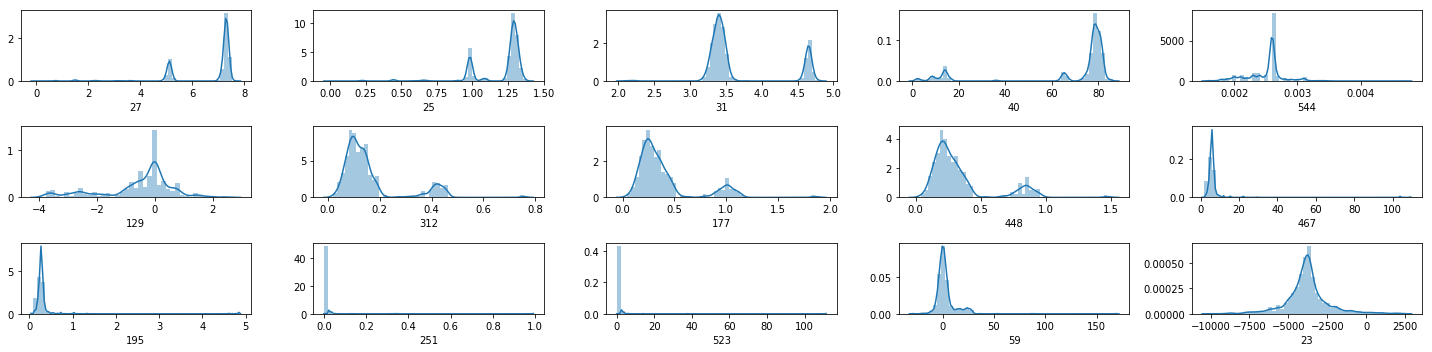

In [29]:
# check distribution of the features that have many outliers

top_outlier_columns = outlier.sort_values(ascending=False).head(15).index # extract top 15 columns based on number of outliers

fig, axs = plt.subplots(3,5,figsize=(20,5))
row = 0
position = 0

for i in range(0,len(top_outlier_columns)): # 
    
    y=top_outlier_columns[i]
    
    # set position of subplot using mod operator
    position = (i+1) % 5
    if  position == 0:
        position = 5 # if 4th position, mod will be 0. Set it to 5.

    # set row of subplot using i
    if ((i+1)%5==1) and i!=0 :
        row = row+1
    
    # boxplot by origin
    sns.distplot(ax = axs[row,position-1],
                 a=p_data[y])
    
    plt.tight_layout()
    
plt.show()

##### Features have multimodes and skews in distribution. Because of lack of subject knowledge, not making any changes to the data

<b>4. Data pre-processing:</b>
<br>
• Segregate predictors vs target attributes
<br>
• Check for target balancing and fix it if found imbalanced.
<br>
• Perform train-test split and standardise the data or vice versa if required.
<br>
• Check if the train and test data have similar statistical characteristics when compared with original data


In [25]:
#independent variable
y=p_data.iloc[:,-1]
#dependent variable
x=p_data.iloc[:,1:-1] #remove timestamp
print(y.value_counts())# check target variable count
print(x.shape)

-1.0    1449
 1.0     100
Name: Pass/Fail, dtype: int64
(1549, 421)


##### Dataset has target imbalance. -1 corresponds to a pass. So, 6% cases in the data corresponds to fail

In [26]:
# Perform train_test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1,stratify=y)
print("Training Class splits\n Total:",len(y_train),Counter(y_train))
print("Testing Class splits\n Total:",len(y_test),Counter(y_test))
print("Input data Class splits\n Total:",len(y),Counter(y))

Training Class splits
 Total: 1084 Counter({-1.0: 1014, 1.0: 70})
Testing Class splits
 Total: 465 Counter({-1.0: 435, 1.0: 30})
Input data Class splits
 Total: 1549 Counter({-1.0: 1449, 1.0: 100})


In [27]:
# looking into stats of some of the key columns for train and test
del col[-1] # delete 'Pass/fail' from analysis

In [28]:
x_train[col].describe()

,21,28,33,59,64,103,121,124,129,210,316,348,431,434,510
count,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000
mean,-5621.366006,69.403414,8.965295,3.186692,20.581575,-0.009736,15.796006,15.794663,-0.572542,0.088804,5.963324,0.024747,22.158606,14.480387,56.306285
std,622.248097,3.477597,1.339842,10.023509,4.996390,0.002955,0.101207,0.115421,1.231343,0.042666,1.024767,0.012327,35.377227,33.296756,39.943561
min,-7150.250000,59.400000,7.603200,-21.205500,6.448200,-0.018500,15.460000,15.430000,-3.779000,0.031900,2.788200,0.010600,0.000000,0.000000,0.000000
25%,-5915.562500,67.286125,8.580000,-1.862725,17.311125,-0.011800,15.730000,15.720000,-0.946100,0.065675,5.312775,0.018175,11.600125,7.565625,35.660075
50%,-5523.250000,69.105550,8.770000,0.999550,20.130450,-0.010100,15.790000,15.775000,-0.141900,0.079800,5.823550,0.022700,16.508700,10.293950,47.301300
75%,-5360.187500,72.111100,9.070725,4.430925,22.932750,-0.008200,15.860000,15.870000,0.047300,0.099025,6.539250,0.027300,21.858425,12.812525,63.559450
max,0.000000,77.344400,23.345300,168.145500,48.312700,0.006200,16.070000,16.100000,2.458000,0.516400,13.095800,0.220000,400.000000,400.000000,451.485100


In [29]:
x_test[col].describe()

,21,28,33,59,64,103,121,124,129,210,316,348,431,434,510
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,-5634.293011,69.922247,8.944137,1.981489,20.524981,-0.010092,15.796796,15.793677,-0.523278,0.088700,6.032064,0.024500,20.973208,13.579839,52.117275
std,582.441146,3.262315,1.378208,7.549620,4.844878,0.003209,0.095610,0.111198,1.201852,0.039685,1.008153,0.010362,31.996830,28.689165,27.967544
min,-7148.000000,60.066700,8.078700,-28.988200,10.747300,-0.032900,15.500000,15.430000,-3.779000,0.036900,3.729300,0.011200,1.699800,0.455800,0.000000
25%,-5946.250000,67.744400,8.573500,-1.929100,17.668200,-0.012100,15.730000,15.730000,-0.851500,0.066500,5.322200,0.018300,10.281900,7.485800,33.962300
50%,-5536.000000,69.633300,8.766200,0.786400,19.904500,-0.010300,15.790000,15.775000,-0.141900,0.079800,5.891400,0.022700,15.899400,9.821600,45.475600
75%,-5346.250000,72.488900,8.997900,3.640000,22.595500,-0.008500,15.870000,15.870000,0.047300,0.098500,6.616900,0.026900,21.417400,12.697200,63.803700
max,-1263.500000,77.900000,23.158300,28.312700,48.988200,0.020300,16.070000,16.090000,2.458000,0.381700,9.287400,0.095000,400.000000,400.000000,210.596000


##### Because of the nature of the dataset, there could be some differences in the distribution of train and test data

In [35]:
#scale input variables
scale = StandardScaler()

# fit with train data
xs_train = pd.DataFrame(scale.fit_transform(x_train), columns=x_train.columns)

# apply mean and std.dev of train data to test data using transform
xs_test = pd.DataFrame(scale.transform(x_test), columns=x_train.columns)

In [36]:
# fix imbalance in target variable using synthetic data
sm = SMOTE(random_state=1) # call SMOTE to resample minority classes in the training dataset
xr_train, yr_train = sm.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(yr_train))

Resampled dataset shape Counter({-1.0: 1014, 1.0: 1014})


In [37]:
# Use synthetic data on scaled variables
sm = SMOTE(random_state=1) # call SMOTE to resample minority classes in the training dataset
xs_r_train, ys_r_train = sm.fit_resample(xs_train, y_train)
print('Resampled dataset shape %s' % Counter(ys_r_train))

Resampled dataset shape Counter({-1.0: 1014, 1.0: 1014})


<b> Train and test sets for classification </b>
<br>
x_train,x_test,y_train,y_test : unscaled features
<br>
xs_train, xs_test, y_train, y_test : scaled features
<br>
xr_train, x_test, yr_train, y_test : unscaled and has synthetic data in the training set
<br>
xs_r_train,xs_test, ys_r_train, y_test : scaled and has synthetic data in the training set

<b>5. Model training, testing and tuning: </b>
• Model training:
- Pick up a supervised learning model.
- Train the model.
- Use cross validation techniques.
Hint: Use all CV techniques that you have learnt in the course.
- Apply hyper-parameter tuning techniques to get the best accuracy.
Suggestion: Use all possible hyper parameter combinations to extract the best accuracies.
- Use any other technique/method which can enhance the model performance.
Hint: Dimensionality reduction, attribute removal, standardisation/normalisation, target balancing etc.
- Display and explain the classification report in detail.
- Design a method of your own to check if the achieved train and test accuracies might change if a different sample population can lead to
new train and test accuracies.
Hint: You can use your concepts learnt under Applied Statistics module.
- Apply the above steps for all possible models that you have learnt so far.
• Display and compare all the models designed with their train and test accuracies.
• Select the final best trained model along with your detailed comments for selecting this model.
• Pickle the selected model for future use.
• Import the future data file. Use the same to perform the prediction using the best chosen model from above. Display the prediction results.

In [188]:
def boostrapCV(model,values,n_iterations=10):
    """
        This function gets the model, dataset as inputs, performs bootstrapping and returns accuracy,precision, recall and f1 as a list
    """
    accuracy = list()
    precision = list()
    recall = list()
    f1 = list()
    
    n_size = int(values.shape[0]*0.5) # size is 50% of length of the passed dataset
   
    for i in range(n_iterations):
        # prepare train and test sets
        train = resample(values, n_samples=n_size)  # Sampling with replacement 
        test = np.array([x for x in values if x.tolist() not in train.tolist()])  # picking rest of the data not considered in sample
        # fit model
        model.fit(train[:,:-1], train[:,-1])
        # evaluate model
        predictions = model.predict(test[:,:-1])
        accuracy.append(accuracy_score(test[:,-1], predictions))
        
        #return precision, recall and f1 of positive labels [label = 'fail']
        precision.append(precision_score(test[:,-1], predictions,pos_label = 1))  #average 'None' returns for both classes
        recall.append(recall_score(test[:,-1], predictions,pos_label=1))
        f1.append(f1_score(test[:,-1], predictions,pos_label=1))
        
#         print(classification_report(test[:,-1], predictions),confusion_matrix(test[:,-1], predictions))
    return accuracy,precision,recall,f1
    

In [184]:
def leaveoneoutCV(model,values):
    """
        This function gets the model, dataset as inputs, performs leaveoneoutcv and returns accuracy,precision, recall and f1 as a list
    """
    
    accuracy = list()
    precision = list()
    recall = list()
    f1 = list()
    
    loocv = LeaveOneOut()
    
    for train, test in loocv.split(values):
        train_set = values[train] # assign training set
        test_set = values[test]   # assign testing set
        model.fit(train_set[:,:-1], train_set[:,-1]) # fit model on training set
        predictions = model.predict(test_set[:,:-1]) # predict on test set
        accuracy.append(accuracy_score(test_set[:,-1], predictions)) # calculate accuracy
        
        #return precision, recall and f1 of positive labels [label = 'fail']
        precision.append(precision_score(test_set[:,-1], predictions)) 
        recall.append(recall_score(test_set[:,-1], predictions))
        f1.append(f1_score(test_set[:,-1], predictions))
        
    return accuracy,precision,recall,f1 

In [132]:
#pick a supervised learning model
rf = RandomForestClassifier(random_state=1)

#Parameters
loss_function= ['gini', 'entropy']
class_weight = ['None','balanced']
n_estimators = range(50,200,10) 
max_depth_range = range(1,5,2)
max_features_range = range(1,250,2) #Total 32 features

#build param_grid
param_grid = dict(criterion=loss_function, n_estimators=n_estimators, max_depth=max_depth_range, class_weight=class_weight, max_features = max_features_range)    # define parameter grid based on these parameters

#Stratified k-fold cross-validation
# rf_grid = GridSearchCV(rf,param_grid, cv=5, scoring='accuracy',n_jobs=-1) # finding best parameters using gridsearch
rf_grid = RandomizedSearchCV(rf,param_grid, n_iter=50, scoring='accuracy',n_jobs=-1) # finding best parameters using gridsearch
rf_grid.fit(xr_train, yr_train) # fit the model

#find best parameters
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.8944924892051329
{'n_estimators': 70, 'max_features': 57, 'max_depth': 3, 'criterion': 'gini', 'class_weight': 'balanced'}


In [189]:
# Bootstrapping 
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_estimators = 70, max_features=57, max_depth=3,random_state=1) # parameters found using tuning
train=pd.concat([xr_train,yr_train],axis = 1)
accuracy,precision,recall,f1  = boostrapCV(rf,train.values,n_iterations=10)
print(mean(accuracy),mean(recall),mean(precision),mean(f1))

0.8889332016924055 0.9355886240000224 0.8552466702803129 0.8934034441959239


In [ ]:
#LeaveOneOut
train=pd.concat([xr_train,yr_train],axis = 1)
accuracy,precision,recall,f1  = leaveoneoutCV(rf,train.values)
print(mean(accuracy),mean(recall),mean(precision),mean(f1))

In [186]:
#model
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_estimators = 70, max_features=57, max_depth=3,random_state=1)
rf.fit(xr_train,yr_train)
y_pred=rf.predict(x_test)
print(classification_report(y_test,y_pred),confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

        -1.0       0.94      0.90      0.92       435
         1.0       0.10      0.17      0.12        30

    accuracy                           0.85       465
   macro avg       0.52      0.53      0.52       465
weighted avg       0.89      0.85      0.87       465
 [[390  45]
 [ 25   5]]


##### Even after using techniques like SMOTE, model doesn't have high recall for the 'Fail' group. 

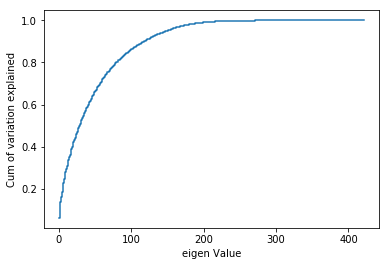

In [190]:
# dimensionality reduction
pca = PCA(n_components=len(x.columns)) 
x_pca_train = pca.fit_transform(xs_train) # fit transform training dataset

# print variance ratio
# print(pca.explained_variance_ratio_)

#graph cumulative variance explained
plt.step(list(range(1,len(x.columns)+1)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

##### Around 150 features can explain 95% of variance

##### Feature selection / Feature removal

In [160]:
x_pca_test = pca.transform(xs_test) #transform the test data

#model
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_estimators = 70, max_features=57, max_depth=3,random_state=1)
rf.fit(x_pca_train[:,:151], y_train)
y_pred = rf.predict(x_pca_test[:,:151])
print(classification_report(y_test,y_pred),confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

        -1.0       0.94      0.99      0.96       435
         1.0       0.25      0.03      0.06        30

    accuracy                           0.93       465
   macro avg       0.59      0.51      0.51       465
weighted avg       0.89      0.93      0.91       465
 [[432   3]
 [ 29   1]]


In [191]:
# apply SMOTE to PCA and check

# fix imbalance in target variable using synthetic data
sm = SMOTE(random_state=1) # call SMOTE to resample minority classes in the training dataset
xr_pca_train, yr_pca_train = sm.fit_resample(x_pca_train[:,:151], y_train)
print('Resampled dataset shape %s' % Counter(yr_train))

rf.fit(xr_pca_train, yr_pca_train)
y_pred = rf.predict(x_pca_test[:,:151])
print(classification_report(y_test,y_pred),confusion_matrix(y_test,y_pred))

Resampled dataset shape Counter({-1.0: 1014, 1.0: 1014})
              precision    recall  f1-score   support

        -1.0       0.95      0.83      0.88       435
         1.0       0.12      0.33      0.17        30

    accuracy                           0.79       465
   macro avg       0.53      0.58      0.53       465
weighted avg       0.89      0.79      0.84       465
 [[359  76]
 [ 20  10]]


##### While accuracy has dropped, recall of 'Fail' category has significantly improved

In [176]:
# Feature elimination using selectKBest
k_range=range(1,101) # for top 100
k_recall = list() # create an empty list
k_accuracy = list() # create an empty list
k_f1score=list() # create an empty list
for k in k_range:
    skb = SelectKBest(k=k)
    x_new_train = skb.fit_transform(xr_train,yr_train) # select top k features
    rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_estimators = 70, max_features=k, max_depth=3,random_state=1)   
    rf.fit(x_new_train, yr_train) # fit model
    y_pred = rf.predict(skb.transform(x_test)) # transform x_test and predict
    k_recall.append(recall_score(y_test,y_pred)) #append recall score of 'Fail' to list
    k_accuracy.append(accuracy_score(y_test,y_pred)) #append accuracy score to list
    k_f1score.append(f1_score(y_test,y_pred)) #append f1score of 'Fail' to list
# print(classification_report(y_test,y_pred),confusion_matrix(y_test,y_pred))

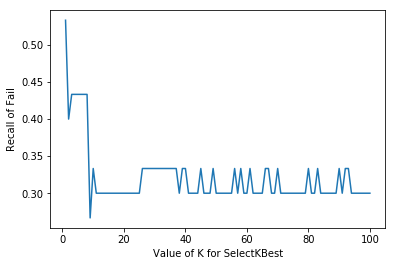

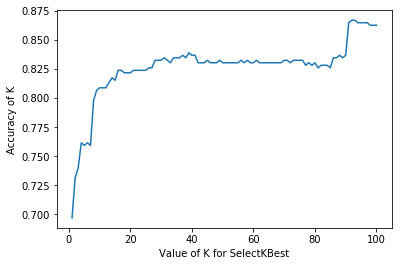

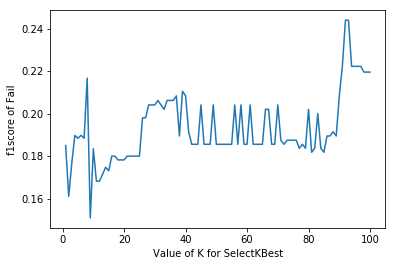

In [177]:
#plot to see clearly
plt.plot(k_range, k_recall)
plt.xlabel('Value of K for SelectKBest')
plt.ylabel('Recall of Fail')
plt.show()

plt.plot(k_range, k_accuracy)
plt.xlabel('Value of K for SelectKBest')
plt.ylabel('Accuracy of K')
plt.show()

plt.plot(k_range, k_f1score)
plt.xlabel('Value of K for SelectKBest')
plt.ylabel('f1score of Fail')
plt.show()

In [178]:
# Feature elimination
k_range=range(1,21) # for top 21
k_f1score=list() # create an empty list
for k in k_range:
    skb = SelectKBest(k=k)
    x_new_train = skb.fit_transform(xr_train,yr_train) # select top k features
    rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_estimators = 70, max_features=k, max_depth=3,random_state=1)   
    rf.fit(x_new_train, yr_train) # fit model
    y_pred = rf.predict(skb.transform(x_test)) # transform x_test and predict
    k_f1score.append(f1_score(y_test,y_pred)) #append f1score of 'Fail' to list
print(k_f1score)

[0.18497109826589597, 0.16107382550335572, 0.1768707482993197, 0.18978102189781024, 0.18840579710144928, 0.18978102189781024, 0.18840579710144928, 0.21666666666666667, 0.1509433962264151, 0.18348623853211007, 0.16822429906542055, 0.16822429906542055, 0.17142857142857143, 0.17475728155339804, 0.17307692307692307, 0.18, 0.18, 0.1782178217821782, 0.1782178217821782, 0.1782178217821782]


In [179]:
features= 8
skb = SelectKBest(k=features)
x_new_train = skb.fit_transform(x_train,y_train) # select top k features
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_estimators = 70, max_features=features, max_depth=3,random_state=1)   
rf.fit(x_new_train, y_train) # fit model
y_pred = rf.predict(skb.transform(x_test)) # transform x_test and predict
print(classification_report(y_test,y_pred),confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

        -1.0       0.95      0.88      0.91       435
         1.0       0.16      0.33      0.22        30

    accuracy                           0.85       465
   macro avg       0.56      0.61      0.57       465
weighted avg       0.90      0.85      0.87       465
 [[383  52]
 [ 20  10]]


##### Only Top 8  have better F1score for 'Fail' class with a slight drop in accuracy

##### Apply all the above steps to all models. This can be done by creating pipelines and comparing the outputs at the end

##### Steps to do
1. Initialize all the classifiers
2. Declare parameter grids for each of these classifiers.
3. Identify SelectKBest for each of these classifiers.
4. Create pipelines
    a. Pipeline 1: which has just the classifier
    b. Pipeline 2: which has scaling and classifier
    c. Pipeline 3: which has scaling, pca and classifier
    d. Pipeline 4: which has scaling, selectkbest and classifier
    e. Pipeline 5: which has selectkbest and classifier [for models that don't require scaling]
5. For model in models
        For pipeline in pipelines
                perform hypertuning and crossvalidation
   we will have len(models)*len(pipelines) as result
6. Select best pipeline for every classifier and build a model on train dataset and test it in test dataset

In [200]:
#Classifiers that require inputs to be scaled
knn = KNeighborsClassifier(n_neighbors=5) 
lr = LogisticRegression(random_state=1) 
sv  = svm.SVC(random_state=1,kernel = 'rbf')

#Classifiers that don't require inputs to be scaled
gnb = GaussianNB()
dtree = DecisionTreeClassifier(random_state=1)

# Ensemble models

#base_Estimators
dtreeR = DecisionTreeClassifier(criterion = 'gini', max_depth=3,random_state=1)

bc = BaggingClassifier(base_estimator=dtreeR, n_estimators=50,random_state=1) 
rf = RandomForestClassifier(n_estimators = 50, max_depth=3,random_state=1)
gb = GradientBoostingClassifier(n_estimators=50,max_depth=3,random_state=1)
ab = AdaBoostClassifier(base_estimator=dtreeR,n_estimators=50, random_state=1)
xgb = XGBClassifier(n_estimators=50,max_depth=3,random_state=1,verbose=0)
cgb = CatBoostClassifier(n_estimators=50,max_depth=3,random_state=1,verbose=0)
lgb = LGBMClassifier(n_estimators=50,max_depth=3,random_state=1,verbose=0)

# Define parameter grids for all the above classifiers
k_range = range(1,31) # find k between 1 and 30 (~sqrt n)
weights = ['uniform', 'distance'] # weighted uniform or by distance
pg_knn = dict(clf__n_neighbors=k_range, clf__weights=weights)    

#Logistic Regression
penal=['l1', 'l2']
class_weight = ['None','balanced']
pg_lr = dict(clf__penalty=penal, clf__class_weight=class_weight)  

# #SVM
C=np.logspace(-3, 2, 6)
gamma =np.logspace(-3, 2, 6)
# kernel = ['linear','rbf']
pg_svm = dict(clf__C=C, clf__gamma=gamma)    


#Decision Tree
loss_function= ['gini', 'entropy']
max_depth = range(1,7,2)
class_weight = ['None','balanced']
pg_dtree = dict(clf__criterion=loss_function, clf__max_depth=max_depth, clf__class_weight=class_weight)

#Random Forest
loss_function= ['gini', 'entropy']
class_weight = ['None','balanced']
n_estimators = range(50,200,10) 
max_depth_range = range(1,5,2)
max_features_range = range(1,250,2) #Total 32 features
pg_rf = dict(clf__criterion=loss_function, clf__n_estimators=n_estimators, clf__max_depth=max_depth_range, clf__class_weight=class_weight, clf__max_features = max_features_range)

#Bagging Classifier
dtreeR_1=DecisionTreeClassifier(criterion = 'gini', max_depth=1, random_state=1)
dtreeR_3=DecisionTreeClassifier(criterion = 'gini', max_depth=3, random_state=1)
dtreeR_ent_1=DecisionTreeClassifier(criterion = 'entropy', max_depth=1, random_state=1)
dtreeR_ent_3=DecisionTreeClassifier(criterion = 'entropy', max_depth=3, random_state=1)
base_estimators = [dtreeR_1,dtreeR_3,dtreeR_ent_1,dtreeR_ent_3]
n_estimators = range(50,160,10) 
pg_bc = dict(clf__base_estimator=base_estimators, clf__n_estimators=n_estimators)    # define parameter grid based on these parameters

# GradientBoosting
n_estimators = range(50,210,10) 
max_depth_range = range(1,6,2)
pg_gb = dict(clf__n_estimators=n_estimators, clf__max_depth=max_depth_range)    # define parameter grid based on these parameters

# AdaBoosting
n_estimators = range(50,210,10) 
base_estimators = [dtreeR_1,dtreeR_3,dtreeR_ent_1,dtreeR_ent_3]
pg_ab=dict(clf__base_estimator=base_estimators,clf__n_estimators=n_estimators)    # define parameter grid based on these parameters

# xgBoost
n_estimators = range(50,210,10) # number of estimators  
max_depth_range = range(1,6,2) # tree depth
learning_rate = [0.1,0.3,0.5] #learning rate
pg_xgb = dict(clf__learning_rate=learning_rate,clf__max_depth=max_depth_range,clf__n_estimators=n_estimators)    # define parameter grid based on these parameters

# CatBoost
n_estimators = range(50,210,10) # number of estimators  
max_depth_range = range(1,6,2) # tree depth
learning_rate = [0.1,0.3,0.5] #learning rate
auto_class_weights=['None','balanced']
pg_cgb = dict(clf__learning_rate=learning_rate,clf__max_depth=max_depth_range,clf__n_estimators=n_estimators,clf__auto_class_weights=auto_class_weights)    # define parameter grid based on these parameters


# LightBoost
n_estimators = range(50,210,10) # number of estimators  
max_depth_range = range(1,6,2) # tree depth
learning_rate = [0.1,0.3,0.5] #learning rate
class_weight=['None','balanced']
pg_lgb = dict(clf__learning_rate=learning_rate,clf__max_depth=max_depth_range,clf__n_estimators=n_estimators,clf__class_weight=class_weight) 

# GaussianNB
pg_gnb = dict()

models = [knn, lr, sv, gnb, dtree, bc, rf, gb, ab , xgb, cgb, lgb]
names = ['KNN', 'Logistic Regression', 'SVM', 'Gaussian NB', 'Decision Tree', 'Bagging Tree', 'Random Forest', 'Gradient Boost', 'Adaboost', 'XGBoost', 'CatBoost', 'LightGB']
param_grid=[pg_knn, pg_lr, pg_svm, pg_gnb, pg_dtree, pg_bc, pg_rf, pg_gb, pg_ab, pg_xgb, pg_cgb, pg_lgb]
scale_models = [knn, lr, sv] #models that require scaling

In [188]:
# find best K (feature elimination) for various models
k_range=range(1,31) # for top 30
k_f1score=pd.DataFrame(columns=names,index=k_range) #create an empty dataframe

for model, name in zip(models,names):
    # Feature elimination using selectKBest
    for k in k_range:
        skb = SelectKBest(k=k) # initialize SelectKBest
        
        # use xr_train and yr_train for models that don't require scaling, else use scaled values
        if model not in scale_models:
            x_new_train = skb.fit_transform(xr_train,yr_train) # select top k features
            model.fit(x_new_train, yr_train) # fit model
            y_pred = model.predict(skb.transform(x_test)) # transform x_test and predict
        else:
            x_new_train = skb.fit_transform(xs_r_train,ys_r_train) # select top k features
            model.fit(x_new_train, ys_r_train) # fit model
            y_pred = model.predict(skb.transform(xs_test)) # transform x_test and predict
        k_f1score.loc[k,name]=round(f1_score(y_test,y_pred)*100,1) #assign f1score of 'Fail' to cell in dataframe


[11:31:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:31:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used bu

[11:31:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:31:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used bu

[11:31:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:31:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used bu

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [193]:
for column in k_f1score.columns:
    k_f1score[column]=k_f1score[column].apply(pd.to_numeric)
    print("Model:",column,"Best K=", k_f1score[column].idxmax())

Model: KNN Best K= 18
Model: Logistic Regression Best K= 26
Model: SVM Best K= 4
Model: Gaussian NB Best K= 1
Model: Decision Tree Best K= 12
Model: Bagging Tree Best K= 8
Model: Random Forest Best K= 24
Model: Gradient Boost Best K= 7
Model: Adaboost Best K= 10
Model: XGBoost Best K= 8
Model: CatBoost Best K= 8
Model: LightGB Best K= 7


In [207]:
pipe_list = ['pipe_model','pipe_sc', 'pipe_sc_pca', 'pipe_sc_skb', 'pipe_skb'] # create names for each piplelines
kbest = pd.Series(index=names,data=[18,26,4,1,12,8,24,7,10,8,8,7])

data_init =  np.zeros((len(pipe_list),len(names))) # initialise 2-d array
results_score = pd.DataFrame(data = data_init,columns=names,index=pipe_list) # dataframe that would hold best recall scores

# each model has separate parameter grids. Using zip to extract base model, its name, and parameter grids
for model, name, pg  in zip(models,names,param_grid): # extract the 3 lists using zip
    
        
#     print("Model:",model,"Name:",name,"Parameter grid:",pg)
    n_best_features = kbest[name] # assign kbest from series
    #create various pipelines for all these models
    pipe_model = Pipeline([('clf', model)])  # simple model is declared as a pipeline to simplify parameter grid processing
    pipe_sc = Pipeline([('scl', StandardScaler()), ('clf', model)]) 
    pipe_sc_pca = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=150)), ('clf', model)]) 
    pipe_sc_skb = Pipeline([('scl', StandardScaler()), ('skb', SelectKBest(k=n_best_features)), ('clf', model)]) 
    pipe_skb = Pipeline([('skb', SelectKBest(k=n_best_features)), ('clf', model)]) 
    
    pipelines = [pipe_model,pipe_sc,pipe_sc_pca,pipe_sc_skb,pipe_skb] # creating a list for all pipelines
    
    # execute pipelines based on conditions
    for pipe_name,pipe in zip (pipe_list,pipelines):
        
              
        if model not in scale_models:
            # then only do pipelines where scaling is not there
            if pipe_name not in ['pipe_sc','pipe_sc_skb']:
                #hyper parameter tuning with cross validation for different pipelines
                grid = RandomizedSearchCV(pipe,pg, n_iter=50, scoring='accuracy',n_jobs=-1) # finding best parameters using gridsearch
                # fit and get hyper parameter values and scores
                grid.fit(xr_train, yr_train) # fit the model                        
                print("Pipe name:",pipe_name,"Name:",name,"Best params:",grid.best_params_) # print best params
                results_score.loc[pipe_name,name] =  round(grid.best_score_*100,2) # populate output dataframe
               

            else:
                pass # don't do anything
                
        else:
            # then do pipelines where scaling is there
            if pipe_name not in ['pipe_model','pipe_skb']:
                #hyper parameter tuning with cross validation for different pipelines
                grid = RandomizedSearchCV(pipe,pg, n_iter=50, scoring='accuracy',n_jobs=-1) # finding best parameters using gridsearch
                grid.fit(xr_train, yr_train) # fit the model                        
                print("Pipe name:",pipe_name,"Name:",name,"Best params:",grid.best_params_) # print best params
                results_score.loc[pipe_name,name] =  round(grid.best_score_*100,2) # populate output dataframe
            else:
                pass # don't do anything
                
results_score

Pipe name: pipe_sc Name: KNN Best params: {'clf__weights': 'uniform', 'clf__n_neighbors': 2}
Pipe name: pipe_sc_pca Name: KNN Best params: {'clf__weights': 'uniform', 'clf__n_neighbors': 2}
Pipe name: pipe_sc_skb Name: KNN Best params: {'clf__weights': 'uniform', 'clf__n_neighbors': 2}
Pipe name: pipe_sc Name: Logistic Regression Best params: {'clf__penalty': 'l2', 'clf__class_weight': 'None'}
Pipe name: pipe_sc_pca Name: Logistic Regression Best params: {'clf__penalty': 'l2', 'clf__class_weight': 'None'}
Pipe name: pipe_sc_skb Name: Logistic Regression Best params: {'clf__penalty': 'l2', 'clf__class_weight': 'None'}
Pipe name: pipe_sc Name: SVM Best params: {'clf__gamma': 0.01, 'clf__C': 10.0}
Pipe name: pipe_sc_pca Name: SVM Best params: {'clf__gamma': 0.01, 'clf__C': 10.0}
Pipe name: pipe_sc_skb Name: SVM Best params: {'clf__gamma': 10.0, 'clf__C': 1.0}
Pipe name: pipe_model Name: Gaussian NB Best params: {}
Pipe name: pipe_sc_pca Name: Gaussian NB Best params: {}
Pipe name: pipe_sk

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Pipe name: pipe_model Name: LightGB Best params: {'clf__n_estimators': 160, 'clf__max_depth': 5, 'clf__learning_rate': 0.3, 'clf__class_weight': 'balanced'}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

Pipe name: pipe_skb Name: LightGB Best params: {'clf__n_estimators': 140, 'clf__max_depth': 5, 'clf__learning_rate': 0.5, 'clf__class_weight': 'balanced'}


,KNN,Logistic Regression,SVM,Gaussian NB,Decision Tree,Bagging Tree,Random Forest,Gradient Boost,Adaboost,XGBoost,CatBoost,LightGB
pipe_model,0.00,0.00,0.00,63.07,84.47,83.43,92.61,99.06,99.56,98.57,98.42,98.87
pipe_sc,77.42,93.84,99.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pipe_sc_pca,81.90,93.29,99.56,96.40,88.22,93.98,97.98,99.95,100.00,99.95,99.90,100.00
pipe_sc_skb,92.60,77.86,85.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pipe_skb,0.00,0.00,0.00,66.17,81.46,78.40,80.52,92.41,93.15,93.74,93.20,93.94


In [202]:
pipe.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [271]:
def fit_n_pred(model, x_train, x_test, y_train, y_test):  
    """
        Purpose: Trains the model that is passed in the input, and tests it with test dataset
        returns: metrics such as accuracy, precision, recall and f1score for both train and test datasets.
                 Also returns fit, prediction and total time
    """
    fit_start = time.time()         #  capture training time 

    model.fit(x_train, y_train)     # fit the model using the train data
    
    fit_end = time.time()           #  capture training time  
    
    y_pred = model.predict(x_test)  # model predictions on the test data
    
#     print("************")
#     print("model:",model)
#     print(classification_report(y_test,y_pred))
#     print("************")
    pred_end = time.time()          #  capture prediction time 
    
    y_train_pred = model.predict(x_train)  # model predictions on the train data
   
    pred_time = pred_end - fit_end  # prediction time
    fit_time = fit_end - fit_start  # fit time
    
    # calculate the metrics on train data - precision, recall and f1 are for y = 1
    accuracy_train = accuracy_score(y_train, y_train_pred)  
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
        
    # calculate the metrics on test data - precision, recall and f1 are for y = 1
    accuracy_test = accuracy_score(y_test, y_pred)  
    precision_test = precision_score(y_test, y_pred)
    recall_test = recall_score(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred)
 
    test_end = time.time()  #Function completion time
    
    total_time = test_end - fit_start  # calculate the total duration
    
    # return all metrics
    return accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, pred_time,fit_time,total_time

def print_results(result):
    """
    Purpose: This function takes input a dictionary and prints the metrics as a dataframe
    returns: dataframe with metrics
    """
    # create dataframe for easy reading of results

    #get values from dictionary
    results_frame = np.array(list(result.values()))

    # round values to single decimal digit
    results_frame = np.round_(results_frame*100,decimals = 1)

    columns = ['Accuracy_Train', 'Precision_Train', 'Recall_Train', 'F1score_Train', 'Accuracy_Test', 'Precision_Test', 'Recall_Test', 'F1score_Test', 'Pred_time', 'Fit_time' , 'Total_time']

    # create dataframe
    result1 = pd.DataFrame(results_frame,columns= columns, index= result.keys())

    return result1

In [272]:
#parameters found using tuning

#Classifiers that require inputs to be scaled
knn_tuned = KNeighborsClassifier(n_neighbors=2,weights = 'uniform') 
lr_tuned = LogisticRegression(penalty='l2',class_weight = 'None') 
sv_tuned  = svm.SVC(gamma =10, C=1,kernel = 'rbf')

#Classifiers that don't require inputs to be scaled
gnb_tuned = GaussianNB()
dtree_tuned = DecisionTreeClassifier(criterion = 'gini', max_depth=5, class_weight = 'balanced', random_state=1)

# Ensemble models
bc_tuned = BaggingClassifier(base_estimator=dtreeR_3, n_estimators=60,random_state=1)
rf_tuned = RandomForestClassifier(criterion='gini', class_weight='balanced', n_estimators = 190, max_features=19, max_depth=3,random_state=1) # parameters found using tuning
gb_tuned = GradientBoostingClassifier(n_estimators =180,max_depth=5,random_state=1)
ab_tuned = AdaBoostClassifier(base_estimator=dtreeR_ent_3,n_estimators=170, random_state=1) 
xgb_tuned = XGBClassifier(learning_rate=0.5,n_estimators=190,max_depth=5,random_state=1,verbose=0)
cgb_tuned = CatBoostClassifier(learning_rate=0.1,n_estimators=190,max_depth=5,random_state=1,verbose=0)
lgb_tuned = LGBMClassifier(learning_rate=0.5,n_estimators=90,max_depth=3,class_weight='balanced',random_state=1,verbose=0,)

In [273]:
# pipeline list corresponding to model based on their performance evaluated in previous run
pipeline=[pipe_sc_skb,pipe_sc_pca,pipe_sc_skb,pipe_sc_pca,pipe_sc_pca,pipe_sc_pca,pipe_sc_pca,pipe_sc_pca,pipe_sc_pca,pipe_sc_pca,pipe_sc_pca,pipe_sc_pca]
# pipeline=[pipe_sc_skb,pipe_sc,pipe_sc_skb,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc]
tuned_models = [knn_tuned, lr_tuned, sv_tuned, gnb_tuned, dtree_tuned, bc_tuned, rf_tuned, gb_tuned, ab_tuned , xgb_tuned, cgb_tuned, lgb_tuned]
result = {}   # Create an empty dictionary to later use to store metrics of each of the models

# call each model in a for loop and store the results in a dictionary with key as 'names' and values as metrics
for model, name,  pipe in zip(tuned_models,names,pipeline):
        
        if pipe  == pipe_sc_skb:
            n_best_features = kbest[name] # assign kbest from series
            pipe.steps[-2]= ('skb', SelectKBest(k=n_best_features))  # cleaning up previous value and assigning correct value for k
        pipe.steps[-1]=('clf',model) # assigning classifier here to clean up previous assignments
#         print("Model:", model,"Name:",name,"Pipe:", pipe)
        result[name] = fit_n_pred(pipe,xr_train, x_test,yr_train, y_test)    

[18:48:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:48:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [270]:
# print final train and test results
result1=print_results(result)
result1.sort_values(by='Accuracy_Test',ascending=False)

,Accuracy_Train,Precision_Train,Recall_Train,F1score_Train,Accuracy_Test,Precision_Test,Recall_Test,F1score_Test,Pred_time,Fit_time,Total_time
Gaussian NB,97.8,100.0,95.6,97.7,93.5,0.0,0.0,0.0,2.3,12.9,19.7
Gradient Boost,100.0,100.0,100.0,100.0,93.5,0.0,0.0,0.0,1.6,1057.0,1061.5
Adaboost,100.0,100.0,100.0,100.0,93.5,0.0,0.0,0.0,6.9,2447.8,2481.4
XGBoost,100.0,100.0,100.0,100.0,93.5,0.0,0.0,0.0,4.9,80.9,90.5
CatBoost,100.0,100.0,100.0,100.0,93.5,0.0,0.0,0.0,5.1,273.4,292.7
LightGB,100.0,100.0,100.0,100.0,93.5,0.0,0.0,0.0,3.2,35.3,43.0
Random Forest,98.5,97.7,99.3,98.5,91.6,0.0,0.0,0.0,2.3,34.5,40.4
Logistic Regression,96.0,92.9,99.6,96.1,85.4,14.8,26.7,19.0,1.3,15.2,20.4
KNN,100.0,100.0,99.9,100.0,85.2,8.5,13.3,10.4,4.5,5.6,23.4
SVM,97.3,97.6,97.0,97.3,83.2,11.3,23.3,15.2,11.9,30.9,89.7


##### Using pca pipeline for most of the above models didn't perform well in recall of 'Fail' label. They seem to be overfitted

In [ ]:
#parameters found using tuning for models without PCA

#Classifiers that require inputs to be scaled
knn_tuned = KNeighborsClassifier(n_neighbors=2,weights = 'uniform') 
lr_tuned = LogisticRegression(penalty='l2',class_weight = 'None') 
sv_tuned  = svm.SVC(gamma =10, C=1,kernel = 'rbf')

#Classifiers that don't require inputs to be scaled
gnb_tuned = GaussianNB()
dtree_tuned = DecisionTreeClassifier(criterion = 'gini', max_depth=5, class_weight = 'balanced', random_state=1)

# Ensemble models
bc_tuned = BaggingClassifier(base_estimator=dtreeR_ent_3, n_estimators=60,random_state=1)
rf_tuned = RandomForestClassifier(criterion='entropy', class_weight='balanced', n_estimators = 50, max_features=5, max_depth=3,random_state=1) # parameters found using tuning
gb_tuned = GradientBoostingClassifier(n_estimators =90,max_depth=5,random_state=1)
ab_tuned = AdaBoostClassifier(base_estimator=dtreeR_ent_3,n_estimators=180, random_state=1) 
xgb_tuned = XGBClassifier(learning_rate=0.1,n_estimators=140,max_depth=5,random_state=1,verbose=0)
cgb_tuned = CatBoostClassifier(learning_rate=0.1,n_estimators=160,max_depth=5,random_state=1,verbose=0)
lgb_tuned = LGBMClassifier(learning_rate=0.3,n_estimators=160,max_depth=5,class_weight='balanced',random_state=1,verbose=0,)

In [274]:
# pipeline list corresponding to model based on their performance evaluated in previous run
pipeline=[pipe_sc_skb,pipe_sc,pipe_sc_skb,pipe_model,pipe_model,pipe_model,pipe_model,pipe_model,pipe_model,pipe_model,pipe_model,pipe_model]
# pipeline=[pipe_sc_skb,pipe_sc,pipe_sc_skb,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc,pipe_sc]
tuned_models = [knn_tuned, lr_tuned, sv_tuned, gnb_tuned, dtree_tuned, bc_tuned, rf_tuned, gb_tuned, ab_tuned , xgb_tuned, cgb_tuned, lgb_tuned]
result = {}   # Create an empty dictionary to later use to store metrics of each of the models

# call each model in a for loop and store the results in a dictionary with key as 'names' and values as metrics
for model, name,  pipe in zip(tuned_models,names,pipeline):
        
        if pipe  == pipe_sc_skb:
            n_best_features = kbest[name] # assign kbest from series
            pipe.steps[-2]= ('skb', SelectKBest(k=n_best_features))  # cleaning up previous value and assigning correct value for k
        pipe.steps[-1]=('clf',model) # assigning classifier here to clean up previous assignments
#         print("Model:", model,"Name:",name,"Pipe:", pipe)
        result[name] = fit_n_pred(pipe,xr_train, x_test,yr_train, y_test)  
# print final train and test results
result1=print_results(result)
result1.sort_values(by='Accuracy_Test',ascending=False)

[19:03:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:03:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

,Accuracy_Train,Precision_Train,Recall_Train,F1score_Train,Accuracy_Test,Precision_Test,Recall_Test,F1score_Test,Pred_time,Fit_time,Total_time
Gradient Boost,100.0,100.0,100.0,100.0,93.1,37.5,10.0,15.8,0.6,3066.9,3069.5
CatBoost,100.0,100.0,100.0,100.0,92.7,25.0,6.7,10.5,19.5,651.0,673.7
LightGB,100.0,100.0,100.0,100.0,92.7,25.0,6.7,10.5,12.0,47.8,75.1
Adaboost,100.0,100.0,100.0,100.0,92.5,0.0,0.0,0.0,7.6,5736.1,5792.5
XGBoost,100.0,100.0,100.0,100.0,92.0,23.1,10.0,14.0,0.7,247.0,250.8
Random Forest,94.4,92.5,96.6,94.5,87.7,17.1,23.3,19.7,1.1,24.4,28.3
Logistic Regression,99.9,99.7,100.0,99.9,86.0,15.7,26.7,19.8,0.5,13.0,15.2
Bagging Tree,85.2,87.0,82.8,84.8,86.0,21.3,43.3,28.6,6.4,1389.0,1429.4
KNN,100.0,100.0,99.9,100.0,85.2,8.5,13.3,10.4,6.5,5.5,24.3
SVM,97.3,97.6,97.0,97.3,83.2,11.3,23.3,15.2,9.1,29.4,79.4


In [276]:
result1.sort_values(by='Recall_Test',ascending=False)

,Accuracy_Train,Precision_Train,Recall_Train,F1score_Train,Accuracy_Test,Precision_Test,Recall_Test,F1score_Test,Pred_time,Fit_time,Total_time
Gaussian NB,61.0,56.4,97.3,71.4,26.7,7.4,90.0,13.7,0.8,2.0,5.8
Bagging Tree,85.2,87.0,82.8,84.8,86.0,21.3,43.3,28.6,6.4,1389.0,1429.4
Decision Tree,90.6,90.3,90.9,90.6,82.4,12.9,30.0,18.0,0.3,32.0,33.6
Logistic Regression,99.9,99.7,100.0,99.9,86.0,15.7,26.7,19.8,0.5,13.0,15.2
SVM,97.3,97.6,97.0,97.3,83.2,11.3,23.3,15.2,9.1,29.4,79.4
Random Forest,94.4,92.5,96.6,94.5,87.7,17.1,23.3,19.7,1.1,24.4,28.3
KNN,100.0,100.0,99.9,100.0,85.2,8.5,13.3,10.4,6.5,5.5,24.3
Gradient Boost,100.0,100.0,100.0,100.0,93.1,37.5,10.0,15.8,0.6,3066.9,3069.5
XGBoost,100.0,100.0,100.0,100.0,92.0,23.1,10.0,14.0,0.7,247.0,250.8
CatBoost,100.0,100.0,100.0,100.0,92.7,25.0,6.7,10.5,19.5,651.0,673.7


 ##### Recall rates for 'Fail' label are much better. But Recall_Train and Recall_Test are quite different either due to overfitting or because test data is slightly different to training set
1. Gaussian NB has very low accuracy.
<br>
2. Between Bagging Tree and Decision Tree, Decision Tree takes much lesser time. Depending upon the complexity of the problem, one of these models can be chosen.
<br>
3. Choosing Decision Tree as it has lesser time taken

In [307]:
# Pickling the final model
model_file = 'Classifer_model.sav'
pickle.dump(dtree_tuned, open(model_file, 'wb')) # dump the model into the model_file

# load the model 
model_dt = pickle.load(open(model_file, 'rb'))
y_pred = model_dt.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        -1.0       0.95      0.86      0.90       435
         1.0       0.13      0.30      0.18        30

    accuracy                           0.82       465
   macro avg       0.54      0.58      0.54       465
weighted avg       0.89      0.82      0.85       465



##### Pickled model's output matches with what we have already.

In [335]:
# import future data
data_future = pd.read_excel("Future_predictions.xlsx",header=0) # read input file
data_future.shape,data_signal.info() # explore shape and info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1549 entries, 0 to 1548
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(591), object(1)
memory usage: 7.0+ MB


((18, 591), None)

In [336]:
data_future.head(18) # check data for the 18 rows

,Time,0,1,2,3,4,5,6,7,8,...,580,581,582,583,584,585,586,587,588,589
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.4966,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100,95.4878,0.1241,1.4436,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100,104.2367,0.1217,1.4882,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
5,2008-07-19 17:53:00,2946.25,2432.84,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5287,...,0.0052,44.0077,0.4949,0.0189,0.0044,3.8276,0.0342,0.0151,0.0052,44.0077
6,2008-07-19 19:44:00,3030.27,2430.12,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.5816,...,NaN,NaN,0.5010,0.0143,0.0042,2.8515,0.0342,0.0151,0.0052,44.0077
7,2008-07-19 19:45:00,3058.88,2690.15,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5153,...,0.0063,95.0310,0.4984,0.0106,0.0034,2.1261,0.0204,0.0194,0.0063,95.0310
8,2008-07-19 20:24:00,2967.68,2600.47,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5358,...,0.0045,111.6525,0.4993,0.0172,0.0046,3.4456,0.0111,0.0124,0.0045,111.6525
9,2008-07-19 21:35:00,3016.11,2428.37,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5381,...,0.0073,90.2294,0.4967,0.0152,0.0038,3.0687,0.0212,0.0191,0.0073,90.2294


In [353]:
# columns of initial dataset are stored as string, while the columns of current dataset are integers. 
#check if both columns match
columns = data_signal.columns[1:-1].values.astype('int32')
(data_future.columns[1:].values - columns).sum()

0

In [355]:
#Both columns match.
# replace future data columns with training dataset columns
data_future.columns = data_signal.columns[:-1]
data_future.columns

Index(['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '580', '581', '582', '583', '584', '585', '586', '587', '588', '589'],
      dtype='object', length=591)

In [356]:
data_future.isnull().sum().sort_values(ascending=False) # check for null values

292     18
358     18
110     18
111     18
382     18
383     18
384     18
157     18
109     18
518     18
517     18
516     18
220     18
244     18
245     18
246     18
293     18
492     18
85      18
158     18
345     10
346     10
72      10
73      10
562      7
385      7
112      7
247      7
563      7
564      7
        ..
351      0
352      0
353      0
354      0
355      0
356      0
357      0
359      0
360      0
361      0
362      0
363      0
364      0
366      0
381      0
367      0
368      0
369      0
370      0
371      0
372      0
373      0
374      0
375      0
376      0
377      0
378      0
379      0
380      0
Time     0
Length: 591, dtype: int64

In [357]:
##### Number of columns that have all nulls. Check model to see if any of these columns are used.
feature_key=pd.Series(data=model_dt.feature_importances_,index=p_data.columns[1:-1])
feature_key.sort_values(ascending=False)

59     0.310136
124    0.099719
103    0.087650
31     0.081327
64     0.059848
22     0.054353
348    0.043478
419    0.038906
125    0.037167
437    0.035341
254    0.034819
305    0.021345
527    0.020301
211    0.018230
271    0.016792
152    0.010747
115    0.010715
353    0.007949
86     0.005616
425    0.002842
572    0.002716
156    0.000000
169    0.000000
168    0.000000
153    0.000000
154    0.000000
155    0.000000
126    0.000000
159    0.000000
165    0.000000
         ...   
409    0.000000
410    0.000000
411    0.000000
412    0.000000
363    0.000000
362    0.000000
361    0.000000
360    0.000000
334    0.000000
335    0.000000
336    0.000000
337    0.000000
338    0.000000
339    0.000000
340    0.000000
341    0.000000
342    0.000000
343    0.000000
344    0.000000
347    0.000000
349    0.000000
350    0.000000
351    0.000000
352    0.000000
354    0.000000
355    0.000000
356    0.000000
357    0.000000
359    0.000000
1      0.000000
Length: 421, dtype: floa

In [363]:
key_index=feature_key[feature_key>0].index.values

In [365]:
key_columns=[key_index]

for column in key_columns:
    print(data_future[column].isnull().sum())

22     0
31     0
59     0
64     0
86     0
103    0
115    0
124    0
125    0
152    0
211    0
254    0
271    0
305    0
348    0
353    0
419    0
425    0
437    0
527    0
572    0
dtype: int64


##### All the key columns used in the decision tree have values and don't have any null values.

In [366]:
p_data_future =data_future.copy() # take a copy of the dataset

# Lets replace null with median values of original data
columns=p_data_future.columns[1:]

for column in columns:
    p_data_future[column].fillna(data_signal[column].median(),inplace=True) #replace null with median values
p_data_future.isnull().sum().sum() #  check for nulls after replacement

0

In [372]:
##### Our pickled model has only 421 features as few of the features were filtered out
model_columns = x_train.columns.values
model_columns

array(['1', '2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '43', '44', '45', '46', '47', '48',
       '50', '51', '53', '54', '55', '56', '57', '58', '59', '60', '61',
       '62', '63', '64', '65', '66', '67', '68', '70', '71', '74', '75',
       '76', '77', '78', '79', '80', '81', '82', '83', '84', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', '96', '98', '99',
       '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '113', '114', '115', '116', '117', '118', '119', '120', '121',
       '122', '123', '124', '125', '126', '127', '128', '129', '130',
       '131', '132', '133', '134', '135', '136', '137', '138', '139',
       '140', '142', '143', '144', '145', '146', '147', '148', '150',
       '151', '152', '153', '154', '155', '156', '159', '160', '161'

In [373]:
# independent variable
x= p_data_future[model_columns] # use only columns used in building model
y_pred = model_dt.predict(x)
print(y_pred) # display results

[-1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1.]


In [376]:
Counter(y_pred) #8/18 fail values 

Counter({-1.0: 10, 1.0: 8})

In [378]:
p_data_future['Pass/Fail'] = y_pred
p_data_future.head(10)

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,...,71.7780,0.5005,0.0118,0.0035,2.3630,0.0207,0.0148,0.0046,71.7780,-1.0
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1.0
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,-1.0
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1.0
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5031,...,71.7780,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1.0
5,2008-07-19 17:53:00,2946.25,2432.84,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5287,...,44.0077,0.4949,0.0189,0.0044,3.8276,0.0342,0.0151,0.0052,44.0077,1.0
6,2008-07-19 19:44:00,3030.27,2430.12,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.5816,...,71.7780,0.5010,0.0143,0.0042,2.8515,0.0342,0.0151,0.0052,44.0077,1.0
7,2008-07-19 19:45:00,3058.88,2690.15,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5153,...,95.0310,0.4984,0.0106,0.0034,2.1261,0.0204,0.0194,0.0063,95.0310,-1.0
8,2008-07-19 20:24:00,2967.68,2600.47,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5358,...,111.6525,0.4993,0.0172,0.0046,3.4456,0.0111,0.0124,0.0045,111.6525,1.0
9,2008-07-19 21:35:00,3016.11,2428.37,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5381,...,90.2294,0.4967,0.0152,0.0038,3.0687,0.0212,0.0191,0.0073,90.2294,1.0


##### Check why train and test data results were quite different using inferential statistics

In [31]:
for column in x_train.columns:
    t_statistic, p_value = ttest_ind(x_train[column], x_test[column])
    if p_value < 0.05:
        print("Column",column,"in train is significantly different to test at 5% level of significance")  

Column 28 in train is significantly different to test at 5% level of significance
Column 29 in train is significantly different to test at 5% level of significance
Column 47 in train is significantly different to test at 5% level of significance
Column 59 in train is significantly different to test at 5% level of significance
Column 75 in train is significantly different to test at 5% level of significance
Column 76 in train is significantly different to test at 5% level of significance
Column 103 in train is significantly different to test at 5% level of significance
Column 115 in train is significantly different to test at 5% level of significance
Column 134 in train is significantly different to test at 5% level of significance
Column 432 in train is significantly different to test at 5% level of significance
Column 483 in train is significantly different to test at 5% level of significance
Column 510 in train is significantly different to test at 5% level of significance
Column 511

##### Some of the key columns such as column 59, 103 etc. used in the model are significantly different between train and test data which could explain why results in test data were quite different

Design a method of your own to check if the achieved train and test accuracies might change if a different sample population can lead to new train and test accuracies.

In [36]:
#independent variable
y=p_data.iloc[:,-1]
#dependent variable
x=p_data.iloc[:,1:-1] #remove timestamp

dtree_test = DecisionTreeClassifier(criterion = 'gini', max_depth=5, class_weight = 'balanced', random_state=1)

for i in range(1,11):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=i,stratify=y)
    dtree_test.fit(x_train,y_train)
    y_pred = dtree_test.predict(x_test)
    y_train_pred = dtree_test.predict(x_train)
    print("Training accuracy score:",round(accuracy_score(y_train, y_train_pred)*100,1), "Testing accuracy score:",round(accuracy_score(y_test, y_pred)*100,1))
    print("Training recall score:",round(recall_score(y_train, y_train_pred)*100,1), "Testing recall score:",round(recall_score(y_test, y_pred)*100,1))    

Training accuracy score: 89.6 Testing accuracy score: 80.4
Training recall score: 94.3 Testing recall score: 13.3
Training accuracy score: 84.8 Testing accuracy score: 76.1
Training recall score: 97.1 Testing recall score: 50.0
Training accuracy score: 81.4 Testing accuracy score: 73.8
Training recall score: 100.0 Testing recall score: 46.7
Training accuracy score: 75.4 Testing accuracy score: 71.2
Training recall score: 100.0 Testing recall score: 56.7
Training accuracy score: 78.6 Testing accuracy score: 68.8
Training recall score: 100.0 Testing recall score: 40.0
Training accuracy score: 79.0 Testing accuracy score: 64.7
Training recall score: 100.0 Testing recall score: 40.0
Training accuracy score: 86.2 Testing accuracy score: 76.1
Training recall score: 95.7 Testing recall score: 30.0
Training accuracy score: 87.5 Testing accuracy score: 77.8
Training recall score: 98.6 Testing recall score: 20.0
Training accuracy score: 81.5 Testing accuracy score: 74.2
Training recall score: 95

##### Training accuracies range from 75% to 90%, while testing accuracies range from 65% to 80%
##### Testing recalls range from 13% to 57%. 

<b>6. Conclusion and improvisation:</b>
• Write your conclusion on the results.

1. The given dataset had features with multimodal distributions, skews with many missing values. Appropriate cleaning techniques were used to handle the same
2. Multiple pipelines were created to evaluate performance of variance classifiers across these pipelines
<br>
    a. Feature Elimination worked for KNN and SVM 
<br>
    b. For other models, Feature reduction using PCA seemed to work in the training dataset, while test results were bad for recall of 'Fail' label
<br>
    c. Using model without PCA gave better results for 'recall'
<br>
    d. Decision Tree and Bagging Classifier performed better for 'recall' of 'Fail' label. While Bagging Classifier had both good accuracy and recall, prediction time seemed to be higher. Hence, Decision Tree model was chosen and pickled for future use.